# Solar Decomposition Models

Knowing the direct or beam normal irradiance (DNI) is useful for many solar and energy applications, e.g., calculating the yield of solar concetrating power systems or determining the irradiance on an inclined surface. However, often only global horizontal irradiance (GHI) is available, as it is much cheaper to measure than the individual components and most satelitte radiation models only calculate GHI. Many applications, therefore, require applying **solar radiation decomposition models** to obtain the direct beam irradiance. The majority of decomposition models work by applying an empirical correlations between GHI, diffuse horizontal irradiance (DHI) and DNI. In this section, we present the implementation in Python of several solar decomposition models. 

***
<div style="text-align: right"> <i>Content by Javier Lopez Lorente and Adam R. Jensen</i> </div>


## The role of solar decomposition models

Solar decomposition models are some of the most frequently used algorithms, and are often used during the first part of a larger analysis. As described earlier, decomposition models permit estimating the beam or direct normal irradiance (DNI) from GHI measurements, often using relationships between the clearness index ($k_t$) and the diffuse fraction of solar irradiance ($k_d$). The clearness index is defined as:

$$ k_t = \frac{GHI}{E_a \cdot cos(\theta_Z)}$$

where $E_a$ is the extraterrestrial irradiance, and $\theta_Z$ is the solar zenith angle. 

The diffuse fraction is defined as: 

$$ k_d = \frac{DHI}{GHI} $$

The role of decomposition models can be graphically illustrated in the diagram below:

```{image} ../notebooks/graphics/decomposition_models.png
:alt: decomposition_flowchart
:class: bg-white mb-1
:width: 500px
:align: center
```


Multiple models have been proposed for the decomposition of global horizontal radiation/irradiance into its direct normal and diffuse horizontal components in the scientific literature. Below, the implementation in Python of some of these methods will be shown. The following methods will be modelled and compared:
- DISC model (Maxwell, 1987)
- DIRINT model (Pérez et al., 1992)
- Erbs model (Erbs et al., 1982) 

The three decomposition models, among some others, are implemented in the open-source library [pvlib python](https://pvlib-python.readthedocs.io/en/stable/api.html#dni-estimation-models).

Before applying the models in practice, an example irradiance data set will be retrieved.

## Data preparation

To illustrate the implementation of each of these models, we will use real irradiance observations. The decomposition models will be used to calculate DNI and DIh from measured GHI, and the results will then be compared to measurements of DNI and DHI. The first step is getting and preparing the measurement data to be used.

In [22]:
# Import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pvlib

### Retrieving weather data

The irradiance data used is from the [BSRN](https://bsrn.awi.de/) Cabauw station operated by the Royal Netherlands Meteorological Institute (KNMI). The data is retrieved from the BSRN FTP server using the `get_bsrn` function from pvlib-python. The Cabauw station is located at latitude 51.9711° and longitude 4.9267°, at an elevation of 0 m AMSL. The data used are 1-minute global, direct, and diffuse irradiance measurements for July 2021.

In [23]:
# Load the BSRN credentials from the Secret environment variables
# This cell is hidden in the displayed notebook
import os
#bsrn_username = os.environ["BSRN_FTP_USERNAME"]
#bsrn_password = os.environ["BSRN_FTP_PASSWORD"]
bsrn_username = 'bsrnftp'
bsrn_password = 'bsrn1'

In [25]:
# Retrieving the measurement data
df, meta = pvlib.iotools.get_bsrn(
    station='CAB',
    start=pd.Timestamp('2021-07-01'),
    end=pd.Timestamp('2021-07-01'),
    username=bsrn_username,
    password=bsrn_password)

# Resample the 1-minute data to hourly
df = df.resample('1h').mean()

# Display the first five rows of the dataset
df.head()

,ghi,ghi_std,ghi_min,ghi_max,dni,dni_std,dni_min,dni_max,dhi,dhi_std,dhi_min,dhi_max,lwd,lwd_std,lwd_min,lwd_max,temp_air,relative_humidity,pressure
2021-07-01 00:00:00+00:00,0.000000,0.081667,-0.066667,0.000000,1.0,0.001667,1.000000,1.0,-0.100000,0.058333,-0.566667,-0.033333,371.750000,0.088333,371.666667,371.866667,13.496667,94.756667,1015.000000
2021-07-01 01:00:00+00:00,-0.300000,0.066667,-0.316667,-0.216667,1.0,0.011667,1.000000,1.0,-0.383333,0.075000,-0.583333,-0.333333,371.133333,0.091667,371.000000,371.333333,13.253333,91.963333,1014.800000
2021-07-01 02:00:00+00:00,0.000000,0.073333,-0.050000,0.000000,1.0,0.003333,1.000000,1.0,-0.150000,0.053333,-0.733333,-0.033333,370.583333,0.101667,370.533333,370.666667,13.185000,88.803333,1014.683333
2021-07-01 03:00:00+00:00,1.633333,0.095000,1.533333,1.750000,1.0,0.006667,1.000000,1.0,1.516667,0.081667,1.466667,1.566667,370.300000,0.105000,370.116667,370.533333,13.091667,90.606667,1014.150000
2021-07-01 04:00:00+00:00,18.600000,0.298333,18.133333,19.283333,1.0,0.011667,0.933333,1.0,18.533333,0.295000,18.083333,19.050000,372.750000,0.145000,372.516667,373.083333,13.050000,93.396667,1014.916667


Besides GHI, DNI and DHI, this station has additional weather-related variables available (e.g., air temperature, humidity, and wind speed), as well as sensor-specific data. The details of the sensors and measurements available in each station can be found under the section "Instrument history and meta data" of each MIDC's station webpage. 

Let's list the variables available and then subset those that we will use in this example:

In [4]:
# Visualize variables avilable
df.columns

Index(['ghi', 'ghi_std', 'ghi_min', 'ghi_max', 'dni', 'dni_std', 'dni_min',
       'dni_max', 'dhi', 'dhi_std', 'dhi_min', 'dhi_max', 'lwd', 'lwd_std',
       'lwd_min', 'lwd_max', 'temp_air', 'relative_humidity', 'pressure'],
      dtype='object')

it is often helpful to visuaize the data, in order to check that the measurements are as expected. For example, a plot for a single day (18th July 2021):

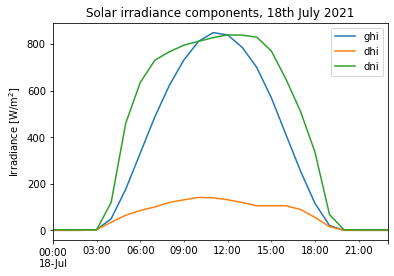

In [26]:
df.loc['2021-07-18', ['ghi','dhi','dni']].plot()
plt.title('Solar irradiance components, 18th July 2021')
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

For an overall representation of the data, it's useful to inspect the the key statistical metrics for the data:

In [27]:
df[['ghi','dni','dhi', 'temp_air', 'relative_humidity', 'pressure']].describe()

,ghi,dni,dhi,temp_air,relative_humidity,pressure
count,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000
mean,202.480422,138.395231,116.982810,17.854637,82.072552,1014.696438
std,246.797927,232.219321,131.685652,2.838482,13.726766,6.274412
min,-1.616667,0.016667,-1.250000,11.378333,42.376667,1000.783333
25%,-0.358333,1.000000,-0.220833,15.839167,71.942500,1009.000000
50%,97.341667,1.975000,72.108333,17.556667,85.485000,1014.075000
75%,358.691667,176.204167,202.495833,19.829167,93.760833,1021.000000
max,890.366667,857.200000,518.416667,25.615000,100.000000,1027.000000


**Estimating other input variables:**

The 3 solar decomposition models that we will implement in this section (i.e., DISC, DIRINT and Erbs models) have different inputs to be implemented. **Solar position data** is a common input for the 3 models. The DISC and DIRINT models accept as a possible input the **dew (wet-bulb) temperature** ($T_d$). This variable is not directly available from our weather observations; however, it can be easily estimated using a simple conversion that has relative humidity ($RH$) and the ambient temperature ($T_a$) as input. This simple approximation is given by the equation below (Lawrence, 2005):

 $$ T_{d} = T_a (^{\circ} C) - \frac{100-RH (\%)}{5} $$
 
In Python, this equation could be implemented as follows:

In [7]:
df['temp_dew'] = df['temp_air']-((100-df['relative_humidity'])/5)

<br>

The solar position for the entire period can be calculated using the `pvlib.solarposition.get_solarposition` function which supports a number of different solar position algorithms. The default algorithm is an implementation of the NREL SPA algorithm.

In [8]:
# Define a pvlib location object for the site
location = pvlib.location.Location(latitude=51.9711, longitude=4.9267, altitude=0, name='Cabauw')

# Calculate the solar position for each index in the datarame for the specific location
solpos = location.get_solarposition(df.index)

# Let's have a look to the output
solpos.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2021-07-01 00:00:00+00:00,104.846052,104.846052,-14.846052,-14.846052,3.778868,-3.817087
2021-07-01 01:00:00+00:00,103.112107,103.112107,-13.112107,-13.112107,17.878551,-3.825129
2021-07-01 02:00:00+00:00,99.263802,99.263802,-9.263802,-9.263802,31.380446,-3.833164
2021-07-01 03:00:00+00:00,93.616677,93.616677,-3.616677,-3.616677,44.046233,-3.841192
2021-07-01 04:00:00+00:00,86.342329,86.550407,3.657671,3.449593,55.895646,-3.849214


## DISC model

The DISC model (Maxwell, 1987) requires the following inputs: GHI, solar zenith angle, and the atmospheric pressure, which is used to estimate the absolute (pressure-corrected) airmass.

In [9]:
# DISC method estimated with absolute airmass as input
disc = pvlib.irradiance.disc(
    ghi=df['ghi'],
    solar_zenith=solpos['apparent_zenith'],
    datetime_or_doy=df.index,
    pressure=df['pressure']*100) # Site pressure in Pascal

The functoin returns the DNI, the clearness index ($k_t$) and the airmass estimation:

In [10]:
disc.columns

Index(['dni', 'kt', 'airmass'], dtype='object')

## DIRINT model

The DIRINT model (Pérez et al., 1992) has also already been implemented pvlib-python. The model requires the following inputs: GHI, solar zenith angle, atmospheric pressure, and dew (wet-bulb) temperature.

In [11]:
# Estimation of the DIRINT model
dirint = pvlib.irradiance.dirint(
    ghi=df['ghi'],
    solar_zenith=solpos['apparent_zenith'],
    times=df.index,
    pressure=df['pressure']*100, # atmospheric pressure in Pascal 
    temp_dew=df['temp_dew']) # Dew temperature in Degree Celsius

## Erbs model

The Erbs model (Erbs et al., 1982) is a simple model that only requires GHI and the solar position through the solar zenith angle. This model is also available in pvlib and the implementation is equally straight-forward:

In [12]:
erbs = pvlib.irradiance.erbs(
    ghi=df['ghi'],
    zenith=solpos['apparent_zenith'],
    datetime_or_doy=df.index)

erbs.columns

Index(['dni', 'dhi', 'kt'], dtype='object')

## Comparison and evaluation of decomposition models

Once the 3 models are estimated, we can evaluate the results of the models against the actual DNI measurements available. For example, below we visualize the results of the models a single day and 1 week in July:


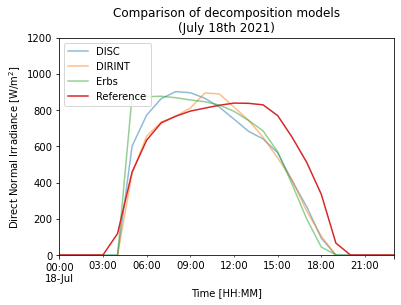

In [13]:
# Plot of models for a single day
date = '2021-07-18'

disc.loc[date, 'dni'].plot(label='DISC', alpha=0.5) # format of date YYYYMMDD
dirint.loc[date].plot(label='DIRINT', alpha=0.5)
erbs.loc[date, 'dni'].plot(label='Erbs', alpha=0.5)
df.loc[date, 'dni'].plot(label='Reference')

plt.ylim(0,1200)
plt.ylabel('Direct Normal Irradiance [W/m$^2$]')
plt.xlabel('Time [HH:MM]')
plt.title('Comparison of decomposition models\n(July 18th 2021)')
plt.legend(loc='upper left')

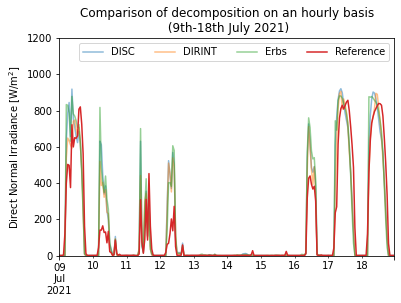

In [14]:
# Plot of models for several days on an hourly basis
disc.loc['20210709':'20210718', 'dni'].resample('1h').mean().plot(label='DISC', alpha=0.5) # format of date YYYYMMDD
dirint.loc['20210709':'20210718'].resample('1h').mean().plot(label='DIRINT', alpha=0.5)
erbs.loc['20210709':'20210718', 'dni'].resample('1h').mean().plot(label='Erbs', alpha=0.5)
df.loc['20210709':'20210718', 'dni'].resample('1h').mean().plot(label='Reference')

plt.ylim(0,1200)
plt.ylabel('Direct Normal Irradiance [W/m$^2$]')
plt.title('Comparison of decomposition on an hourly basis\n (9th-18th July 2021)')
plt.legend(ncol=4)

The correlation between the obtained models and the measured observations can be also presented in **scatter plots**:

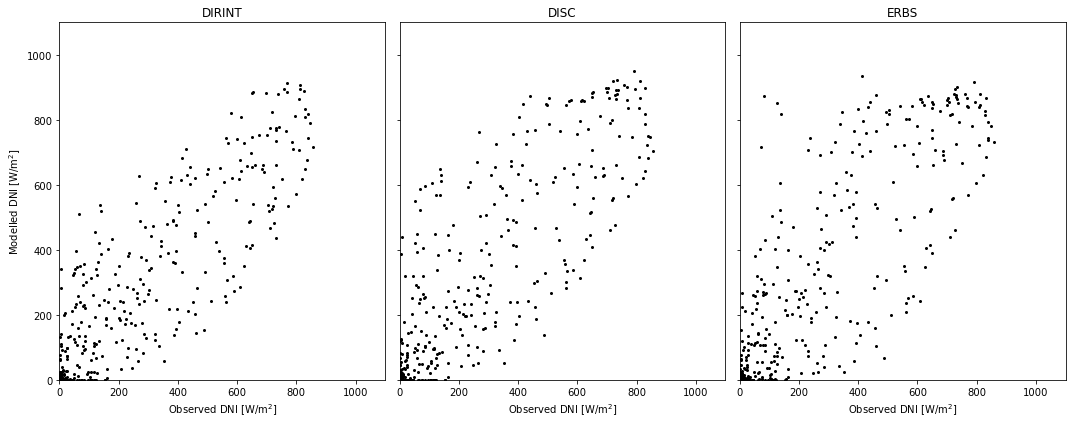

In [21]:
# Create multiple plots
fig, axes = plt.subplots(1,3, figsize=(15, 6), facecolor='w', edgecolor='k', sharey=True)

# Plot
axes[0].scatter(df['dni'], dirint, s=4, c='k')
axes[1].scatter(df['dni'], disc['dni'], s=4, c='k')
axes[2].scatter(df['dni'], erbs['dni'], s=4, c='k')

# Add characteristics to each subplot in a loop
axes[0].set_ylabel('Modelled DNI [W/m$^2$]')
axes[0].set_ylim(0, 1100)

for ax, model in zip(axes, ['DIRINT', 'DISC', 'ERBS']):
    ax.set_xlim(0, 1100)
    ax.set_title(model)
    ax.set_xlabel('Observed DNI [W/m$^2$]')

plt.tight_layout()
plt.show()

The evaluation cannot be only based on a visual inspection. For solar resource assessment, there are a number of common metrics to evaluate the error and performance, which we will use below. These metrics are the mean bias error (MBE) and the root mean square error (RMSE). The MBE is the average error representing a systematic error to under- or overestimate and the RMSE is a measure of the dispersion of the deviations.

$$ MBE = \frac{1}{n} \sum_{i=1}^{n} M_i - O_i $$

$$ RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}{(M_i - O_i)^2}}$$

where $n$ is the size of the sample or dataset, $M_i$ is each of the predicted values and $O_i$ are the observed or true values. In Python, each of these evaluation metrics can be defined as function.


In [16]:
# Mean Bias Error
def mbe(predictions, observed):
    return (predictions - observed).mean()

# Root Mean Square Error 
def rmse(predictions, observed):
    return np.sqrt(((predictions - observed)**2).mean())

The performance metrics for DNI estimations can be obtained using these functions. 

For the DISC method:

In [17]:
mbe_disc = mbe(disc['dni'], df['dni'])
rmse_disc = rmse(disc['dni'], df['dni'])

print("DISC Decomposition Method:")
print("MBE " + "%.2f" % mbe_disc + " W/m\u00b2")
print("RMSE " + "%.2f" % rmse_disc + " W/m\u00b2")

DISC Decomposition Method:
MBE 22.57 W/m²
RMSE 124.58 W/m²


For the DIRINT method:

In [18]:
mbe_dirint = mbe(dirint, df['dni'])
rmse_dirint = rmse(dirint, df['dni'])

print("DIRINT Decomposition Method:")
print("MBE " + "%.2f" % mbe_dirint + " W/m\u00b2")
print("RMSE " + "%.2f" % rmse_dirint + " W/m\u00b2")

DIRINT Decomposition Method:
MBE 8.01 W/m²
RMSE 122.37 W/m²


For the Erbs method:

In [19]:
mbe_erbs = mbe(erbs['dni'], df['dni'])
rmse_erbs = rmse(erbs['dni'], df['dni'])

print("Erbs Decomposition Method:")
print("MBE " + "%.2f" % mbe_erbs + " W/m\u00b2")
print("RMSE " + "%.2f" % rmse_erbs + " W/m\u00b2")

Erbs Decomposition Method:
MBE 25.89 W/m²
RMSE 138.94 W/m²


The performance metrics show that, in this example, the Erbs method reports the lowest error metrics, closely followed by the DISC and the DIRINT methods, respectively.

## Section summary

This section has presented the solar radiation decomposition methods, which are a common type of technique to estimate the direct normal or beam irradiance from global horizontal irradiance observations. Particularly, the following examples have been covered: <br>
- The Python implementation of three solar radiation decomposition methods have been presented using real data, namely the models used are the DISC, DIRINT and Erbs models. <br>
- Time-series visualization and scatter plots have been introduced to evaluate differences in the models. <br>
- Two common error metrics to evaluate the performance, i.e. MBE and RMSE, have been introduced. <br>

Within solar resource assessment, decomposition methods are used as means to estimate the direct irradiance or irradiation for further analysis in particular applications. For example, in solar concentrating power where direct irradiance is essential for power generation availability. There are multiple decomposition methods available in the literature. However, the Python functions for these 3 methods are available in the Python library *pvlib*.

***

## References

Andreas, A., and Wilcox, S., (2010). 'Observed atmospheric and solar information system (OASIS)', Tucson, Arizona (Data), NREL Report No. DA-5500-56494. http://dx.doi.org/10.5439/1052226

Erbs, D. G., Klein, S. A., and Duffie, J. A., (1982). 'Estimation of the diffuse radiation fraction for hourly, daily and monthly-average global radiation', Solar Energy 28(4), pp 293-302.

Gueymard, C. A and Ruiz-Arias, J. A., (2016). 'Extensive worldwide validation and climate sensitivity analysis of direct irradiance predictions from 1-min global irradiance', Solar Energy 128, pp 1-30.

Lawrence, M. G. (2005). 'The relationship between relative humidity and the dewpoint temperature in moist air: A simple conversion and applications', Bulletin of the American Meteorological Society, 86(2), pp. 225-234. https://doi.org/10.1175/BAMS-86-2-225

Maxwell, E. L., (1987). 'A quasi-physical model for converting hourly global horizontal to direct normal insolation', Technical Report No. SERI/TR-215-3087, Golden, CO: Solar Energy Research Institute.

Perez, R., Ineichen, P., Maxwell, E.,  Seals, R., and Zelenka, A., (1992). 'Dynamic global-to-direct irradiance conversion models'. ASHRAE Transactions-Research Series, pp. 354-369